## SVR Model

- Training data made with some overlap
- feature set 4; ie with fft components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 4

#### 1) Extract dataset with features and target from csv files

In [2]:
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    kwargs = {'gen_features' : gen_features.gen_features4,
              'overlap_ratio' : 0.5,
             }
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset,args=(k,),kwargs=kwargs)
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k))).iloc[:,1:] for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set{}.csv".format(fset)))
else:
    print("Feature set {} already extracted.".format(fset))
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset))).iloc[:,1:]

Feature set 4 already extracted.


In [3]:
x_df_raw = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

In [4]:
data.tail()

,mean,std,max,min,skew,kurtosis,r10_std,r100_std,r1000_std,1diff_mean,1diff_std,2diff_std,cumsum_max,num > q0.995,time_to_failure
16709,4.489550,3.454761,64,-66,-0.108652,15.753992,1.575053,0.355076,0.213360,0.000047,3.157097,4.821477,3866.306831,732,9.760800
16710,4.479615,3.448699,64,-66,-0.139434,17.734203,1.586974,0.356590,0.214267,-0.000017,3.151585,4.813932,5418.292098,599,9.759796
16711,4.493480,3.670229,64,-66,-0.171886,19.836235,1.712873,0.359228,0.214935,0.000000,3.189568,4.817990,4912.382225,379,9.759796
16712,4.565128,3.282740,46,-33,0.013554,6.720458,1.451719,0.354214,0.217487,0.000022,3.133986,4.815550,2919.347230,223,9.759796
16713,4.648496,3.151858,26,-13,0.084372,1.003229,1.363908,0.311552,0.160577,-0.000627,3.107681,4.784565,375.255639,39,9.759796


#### 2) Normalize the data

In [5]:
scaler = StandardScaler()
x_df = scaler.fit_transform(x_df_raw.astype(np.float64))

#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

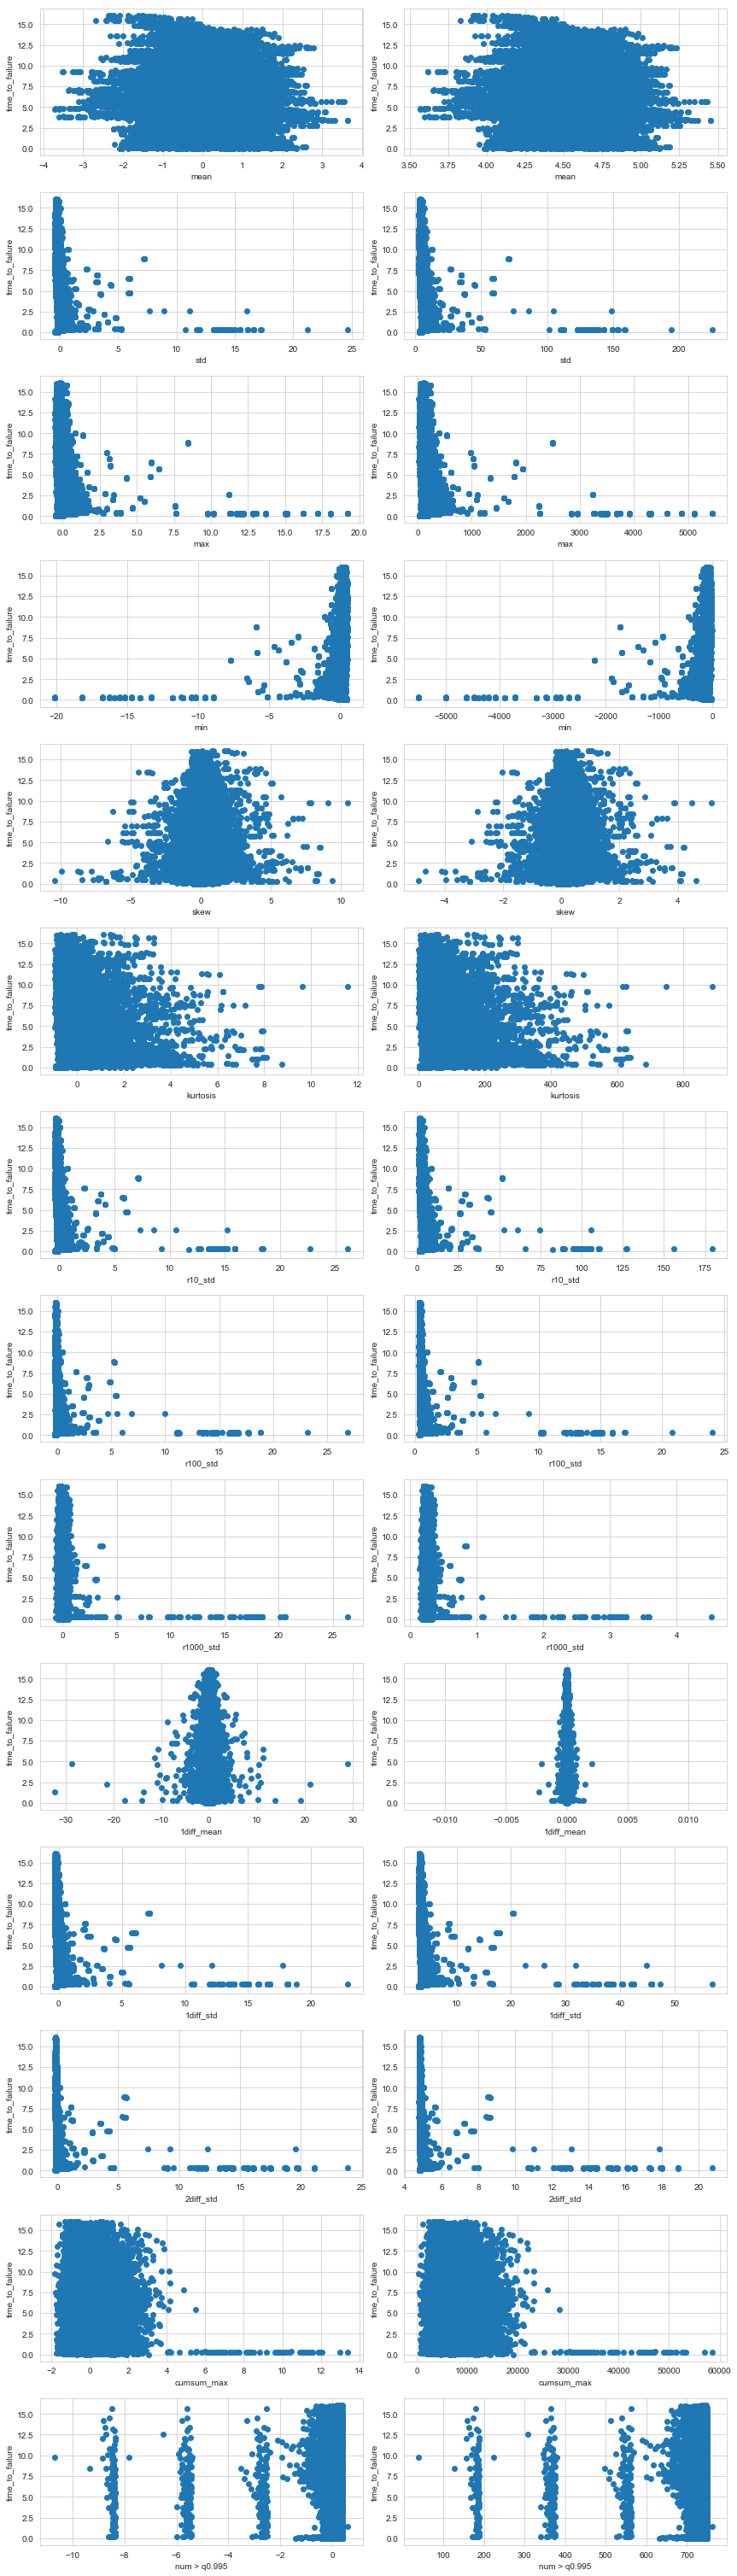

In [6]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,2,figsize = (12,nrows*3))

for i,axis in enumerate(axes):
    axis[0].scatter(x_df[:,i],y_df)
    axis[0].set_xlabel(x_df_raw.columns[i])
    axis[0].set_ylabel('time_to_failure')
    
    axis[1].scatter(x_df_raw.iloc[:,i],y_df)
    axis[1].set_xlabel(x_df_raw.columns[i])
    axis[1].set_ylabel('time_to_failure')
    
plt.tight_layout()

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up a model with SVR

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [9]:
regressor = SVR(kernel='rbf',gamma='auto')
res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5)

print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res),np.std(res)))

Mean CV score: -2.238, Std. Dev. of CV scores 0.051


In [11]:
# Make a final benchmark model by training on the entire training data
from sklearn.base import clone
regressor_final = clone(regressor)
regressor_final = regressor_final.fit(X_train,y_train.values.ravel())

In [12]:
%%time
from sklearn.model_selection import GridSearchCV

params = {'gamma' : [0.1,0.2,0.5],
          'C' : [1,4,7,10],
          }

grid = GridSearchCV(regressor_final,param_grid=params,scoring='neg_mean_absolute_error',
                   cv = 4)
grid.fit(X_train,y_train)

Wall time: 5min 5s


In [13]:
grid.best_score_

-2.174660734846437

In [14]:
grid.best_params_

{'C': 4, 'gamma': 0.2}

Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

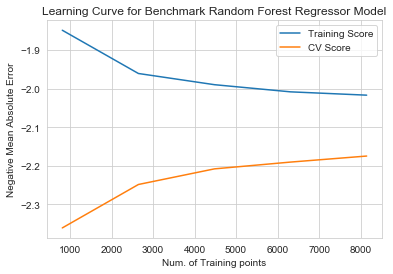

In [16]:
from sklearn.model_selection import learning_curve
best_regr = grid.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(
    best_regr,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for SVR Model')

In [17]:
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

train_score = mean_absolute_error(y_train,y_train_pred)
test_score = mean_absolute_error(y_test,y_test_pred)

print(train_score)
print(test_score)

2.0234300257088673
2.1525398329173857


In [19]:
svr_pred = pd.DataFrame(best_regr.predict(scaler.transform(data.iloc[:,:-1])),
                        index=data.index,columns = ['SVR_fset{} Prediction'.format(fset)])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


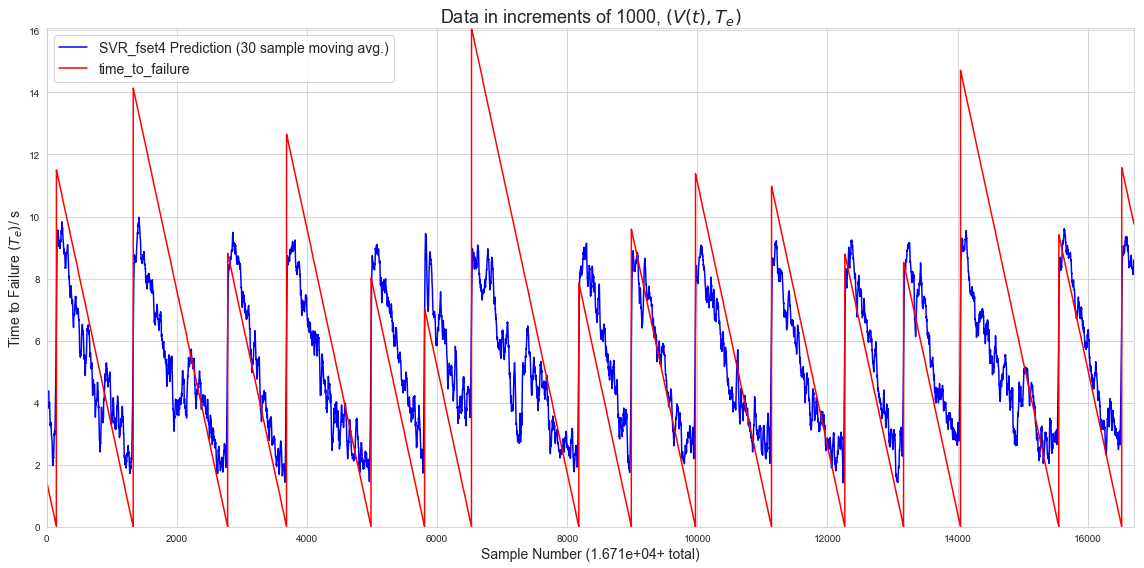

In [25]:
xdata = data.iloc[:,:-1]
fig,axis = plt.subplots(figsize=(16,8))
window = 30
axis.plot(svr_pred.rolling(window).mean(),'b',
          label="SVR_fset{} Prediction ({} sample moving avg.)".format(fset,window))
axis.plot(data['time_to_failure'],'r')
plt.legend(fontsize=14)
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel(r'Time to Failure $(T_e)$/ s',fontsize=14)
plt.title(r'Data in increments of 1000, $(V(t), T_e)$',fontsize=18)
plt.xlabel(r'Sample Number ({:.3e}+ total)'.format(data.index[-1]),fontsize=14)
plt.tight_layout()
plt.savefig("benchmark_model")